# PROPUESTA
Diseñar un algoritmo de aprendizaje de máquina que permita clasificar los poligonos de Google como nuevos o existentes dependiendo del cruce que se realice con el conjunto de datos de poligonos de Catastro IGAc para el municipio entregado.

Tener en cuenta:
El modelo de clasificación deberá ser realizado con regresión logística
El ejercicio de deberá contemplar las fases vistas en clase, a. exploración de datos, b. identificación o construcción de variables independientes y dependiente.
Establecer los puntos críticos que deben ser contemplados en un clasificador, umbral de decisión definido por el científico de datos, entrenamientos realizados, cambios en los parámetros o hiperparámetros.
realizar varias iteraciones y evaluaciones de métricas que evidencen las mejoras en el comportamiento del modelo
Identificar y presentar las decisiones que se tomaron dentro del proceso, asociadas a balanceo de datos, transformación de características, construcción de variable objetivo.
Generar un nueva capa de poligonos de Google con la etiqueta NUEVO-EXISTENTE 
Mediante QGIS mostrar en una imagen la comparación entre poligonos de google etiquetados versus poligonos de catastro
Entregar un archivo de Notebook de Python .ipynb con todo el proceso documentado.

## Imports.

In [40]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from sklearn.metrics import classification_report, accuracy_score,roc_curve, auc

import pickle

import utils.basicosModelos
importlib.reload(utils.basicosModelos)
from utils.basicosModelos import cargar_datos,escalar_datos,dividir_datos, optimizar_hiperparametros_logistica



In [2]:
import geopandas as gpd

# Cargar los archivos directamente con GeoPandas
gdf_catastro = gpd.read_parquet('./data/gdf_catastro.parquet')
gdf_google = gpd.read_parquet('./data/gdf_google_actualizado.parquet')

# Asegurar que ambos tengan el mismo sistema de coordenadas
gdf_google = gdf_google.set_crs(gdf_catastro.crs, allow_override=True)


In [3]:
gdf_catastro.columns

Index(['FID_U_CONS', 'CODIGO', 'TERRENO_CO', 'TIPO_CONST', 'TIPO_DOMIN',
       'NUMERO_PIS', 'NUMERO_SOT', 'NUMERO_MEZ', 'NUMERO_SEM', 'ETIQUETA',
       'IDENTIFICA', 'CODIGO_EDI', 'CODIGO_ANT', 'USUARIO_LO', 'FECHA_LOG',
       'GLOBALID_S', 'SHAPE_Leng', 'SHAPE_Area', 'codigo_mun', 'CODIGO_DEP',
       'FID_R_CONS', 'CODIGO_1', 'TERRENO__1', 'TIPO_CON_1', 'TIPO_DOM_1',
       'NUMERO_P_1', 'NUMERO_S_1', 'NUMERO_M_1', 'NUMERO_S_2', 'ETIQUETA_1',
       'IDENTIFI_1', 'CODIGO_E_1', 'CODIGO_A_1', 'USUARIO__1', 'FECHA_LO_1',
       'GLOBALID_1', 'SHAPE_Le_1', 'SHAPE_Ar_1', 'codigo_m_1', 'CODIGO_D_1',
       'geometry'],
      dtype='object')

In [4]:
gdf_google.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           18299 non-null  object  
 1   area_in_me                   18299 non-null  float64 
 2   confidence                   18299 non-null  float64 
 3   full_plus_                   18299 non-null  object  
 4   longitude_                   18299 non-null  object  
 5   area_m2                      18299 non-null  float64 
 6   geometry                     18299 non-null  geometry
 7   origen                       18299 non-null  object  
 8   UOI                          18299 non-null  float64 
 9   ObjectID                     18299 non-null  float64 
 10  Index_uoi                    18299 non-null  float64 
 11  Hausdorff_Distance           18299 non-null  float64 
 12  Most_Similar_ObjectID        18299 non-null  float64

In [5]:
gdf_google.columns

Index(['id', 'area_in_me', 'confidence', 'full_plus_', 'longitude_', 'area_m2',
       'geometry', 'origen', 'UOI', 'ObjectID', 'Index_uoi',
       'Hausdorff_Distance', 'Most_Similar_ObjectID', 'Centroid_Distance',
       'neighbors_count', 'google_mbr_angle_deg', 'google_mbr_direction',
       'catastro_mbr_angle_deg', 'catastro_mbr_direction',
       'adjusted_catastro_mbr_angle', 'angle_difference', 'num_intersections',
       'combined_area', 'combined_UOI', 'google_centroid_x',
       'google_centroid_y', 'catastro_centroid_x', 'catastro_centroid_y',
       'hausdorff_to_combined', 'classification_score'],
      dtype='object')

No tiene datos nulos

In [6]:
gdf_google.describe()

c:\Users\Andre\anaconda3\envs\ML01\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,area_in_me,confidence,area_m2,UOI,ObjectID,Index_uoi,Hausdorff_Distance,Most_Similar_ObjectID,Centroid_Distance,neighbors_count,...,angle_difference,num_intersections,combined_area,combined_UOI,google_centroid_x,google_centroid_y,catastro_centroid_x,catastro_centroid_y,hausdorff_to_combined,classification_score
count,18299.000000,18299.000000,18299.000000,18299.000000,18299.000000,18299.000000,1.829900e+04,18299.000000,18299.000000,18299.000000,...,18299.000000,18299.000000,18299.000000,18299.000000,1.829900e+04,18299.000000,1.829900e+04,18299.000000,18299.000000,18299.000000
mean,148.212409,0.782054,147.565139,0.268060,39558.655828,6843.333953,inf,40504.111591,2.824359,1.920214,...,86.534187,1.920214,88.337179,0.239191,1.041456e+06,883876.289002,7.430030e+05,630666.866397,8.118376,-329.002652
std,182.970311,0.062950,182.171090,0.238560,27302.127104,6309.038529,NaN,26928.079906,4.226222,2.234155,...,50.685073,2.234155,145.551301,0.217965,1.039877e+03,1292.359768,4.709184e+05,399719.878141,9.627407,292.546919
min,3.884800,0.650100,3.865280,0.000000,-1.000000,-1.000000,4.467895e-01,-1.000000,-1.000000,0.000000,...,0.000246,0.000000,0.000000,0.000000,1.036346e+06,878742.453744,0.000000e+00,0.000000,-1.000000,-1326.004017
25%,62.619400,0.737700,62.330250,0.000000,-1.000000,-1.000000,4.721944e+00,-1.000000,-1.000000,0.000000,...,77.749916,0.000000,0.000000,0.000000,1.040822e+06,883213.664557,0.000000e+00,0.000000,-1.000000,-442.863907
50%,100.466301,0.784400,100.022000,0.261136,53816.000000,5755.000000,8.921398e+00,54073.000000,2.199666,2.000000,...,89.332740,2.000000,52.496090,0.225269,1.041380e+06,883891.998975,1.041035e+06,883465.645057,6.673634,-426.291696
75%,170.197395,0.827400,169.474500,0.446343,60479.500000,12510.500000,NaN,60611.500000,4.283240,3.000000,...,95.896555,3.000000,112.642002,0.403308,1.042245e+06,884679.321051,1.041643e+06,884362.621837,12.466246,10.000000
max,5030.658300,0.961900,5008.420000,0.932200,67994.000000,19735.000000,inf,67997.000000,57.325135,79.000000,...,266.239051,79.000000,4198.655481,0.930078,1.046119e+06,888949.386860,1.043635e+06,886360.701576,113.691508,119.540577


In [7]:
# Convertir a numérico (para evitar problemas con datos no numéricos)
numeric_cols = gdf_google.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    print(f" Revisando {col}...")
    print(f"    - Valores infinitos: {np.isinf(gdf_google[col]).sum()}")
    print(f"    - Valores NaN: {gdf_google[col].isna().sum()}")
    print(f"    - Máximo: {gdf_google[col].max()}")
    print(f"    - Mínimo: {gdf_google[col].min()}")

 Revisando area_in_me...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 5030.6583
    - Mínimo: 3.88479995728
 Revisando confidence...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 0.9619
    - Mínimo: 0.6501
 Revisando area_m2...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 5008.42
    - Mínimo: 3.86528
 Revisando UOI...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 0.9322004794604764
    - Mínimo: 0.0
 Revisando ObjectID...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 67994.0
    - Mínimo: -1.0
 Revisando Index_uoi...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 19735.0
    - Mínimo: -1.0
 Revisando Hausdorff_Distance...
    - Valores infinitos: 4895
    - Valores NaN: 0
    - Máximo: inf
    - Mínimo: 0.44678949077466495
 Revisando Most_Similar_ObjectID...
    - Valores infinitos: 0
    - Valores NaN: 0
    - Máximo: 67997.0
    - Mínimo: -1.0
 Revisando Centroid_Distance...
    - Valor

Eliminando los infinitos de la columna Hausdorff_Distance

In [8]:
# Contar cuántos valores infinitos hay en la columna
inf_count = np.isinf(gdf_google["Hausdorff_Distance"]).sum()
proportion = inf_count / len(gdf_google["Hausdorff_Distance"])
# Reemplazar infinitos por la mediana de los valores finitos
median_value = gdf_google.loc[np.isfinite(gdf_google["Hausdorff_Distance"]), "Hausdorff_Distance"].median()
gdf_google["Hausdorff_Distance"] = gdf_google["Hausdorff_Distance"].replace([np.inf, -np.inf], median_value)

print("Resumen después de limpiar:")
print(gdf_google["Hausdorff_Distance"].describe())

# Confirmar que ya no hay valores infinitos
print("Valores infinitos después de limpiar:", np.isinf(gdf_google["Hausdorff_Distance"]).sum())



Resumen después de limpiar:
count    18299.000000
mean         7.795091
std          6.558642
min          0.446789
25%          4.721944
50%          6.370264
75%          8.506198
max        126.135245
Name: Hausdorff_Distance, dtype: float64
Valores infinitos después de limpiar: 0


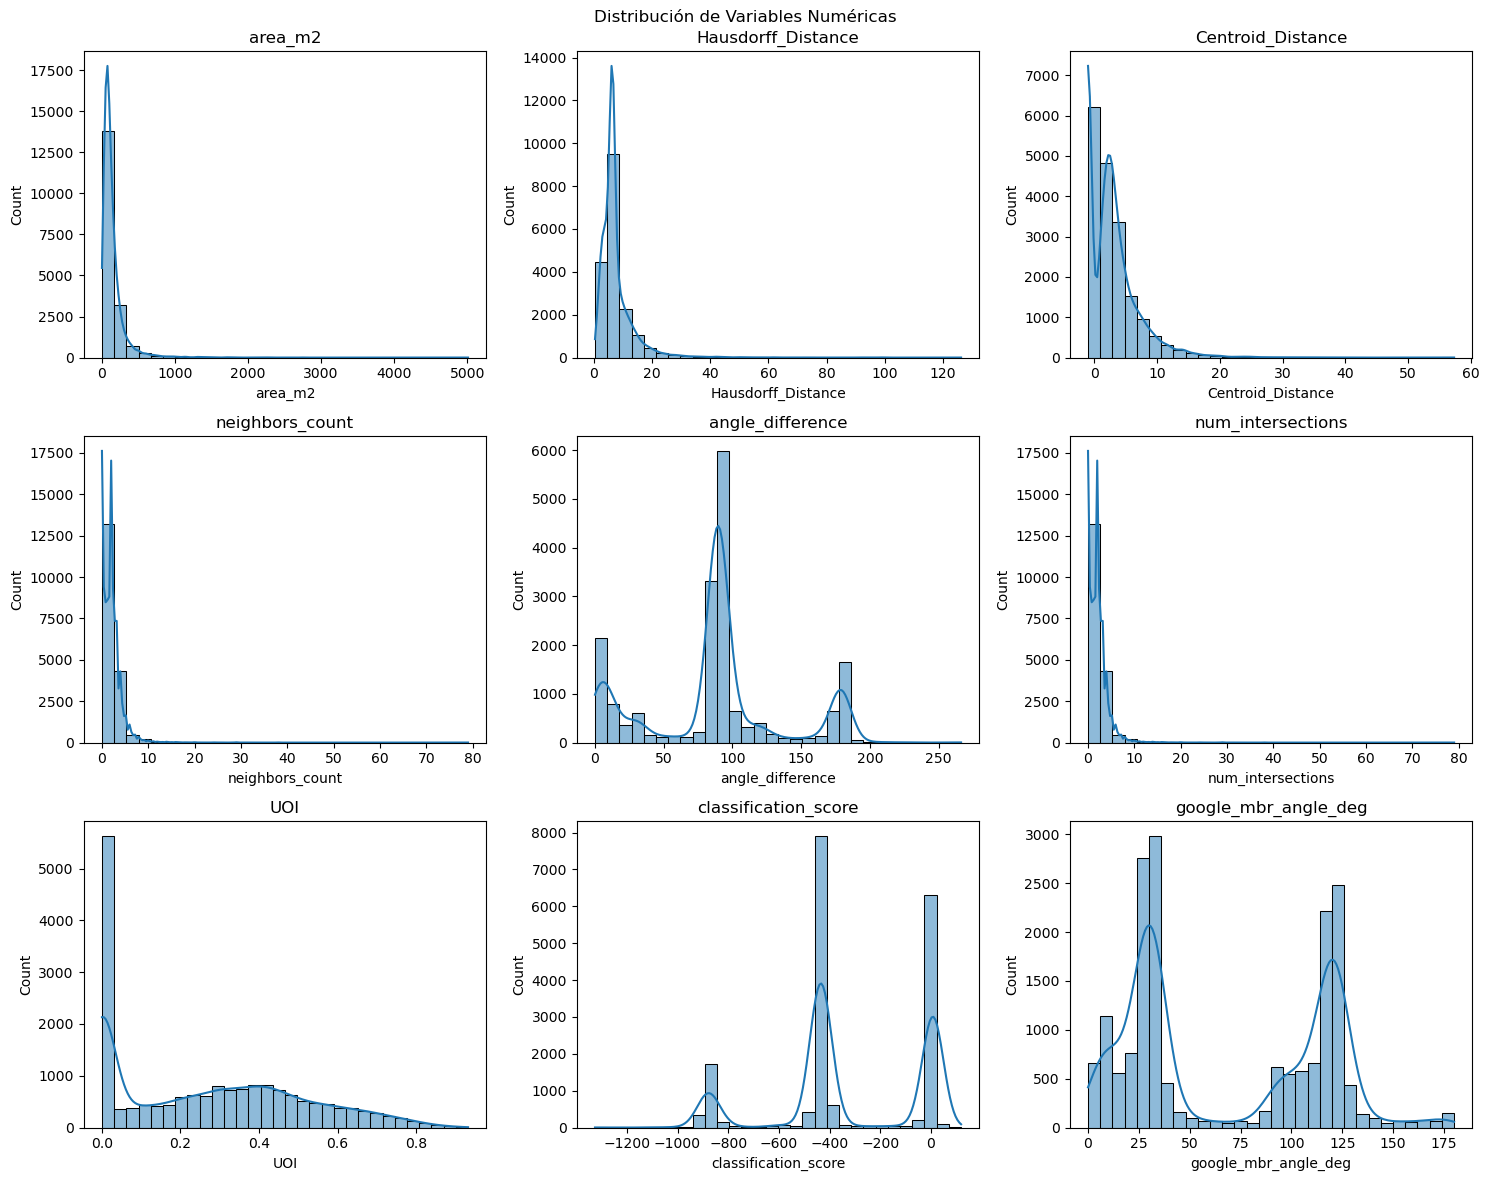

In [9]:
# Gráficos de distribución para las principales variables
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Distribución de Variables Numéricas")

variables = ['area_m2', 'Hausdorff_Distance', 'Centroid_Distance', 
             'neighbors_count', 'angle_difference', 'num_intersections', 
             'UOI', 'classification_score', 'google_mbr_angle_deg',]

for i, var in enumerate(variables):
    sns.histplot(gdf_google[var], bins=30, kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(var)

plt.tight_layout()
plt.show()


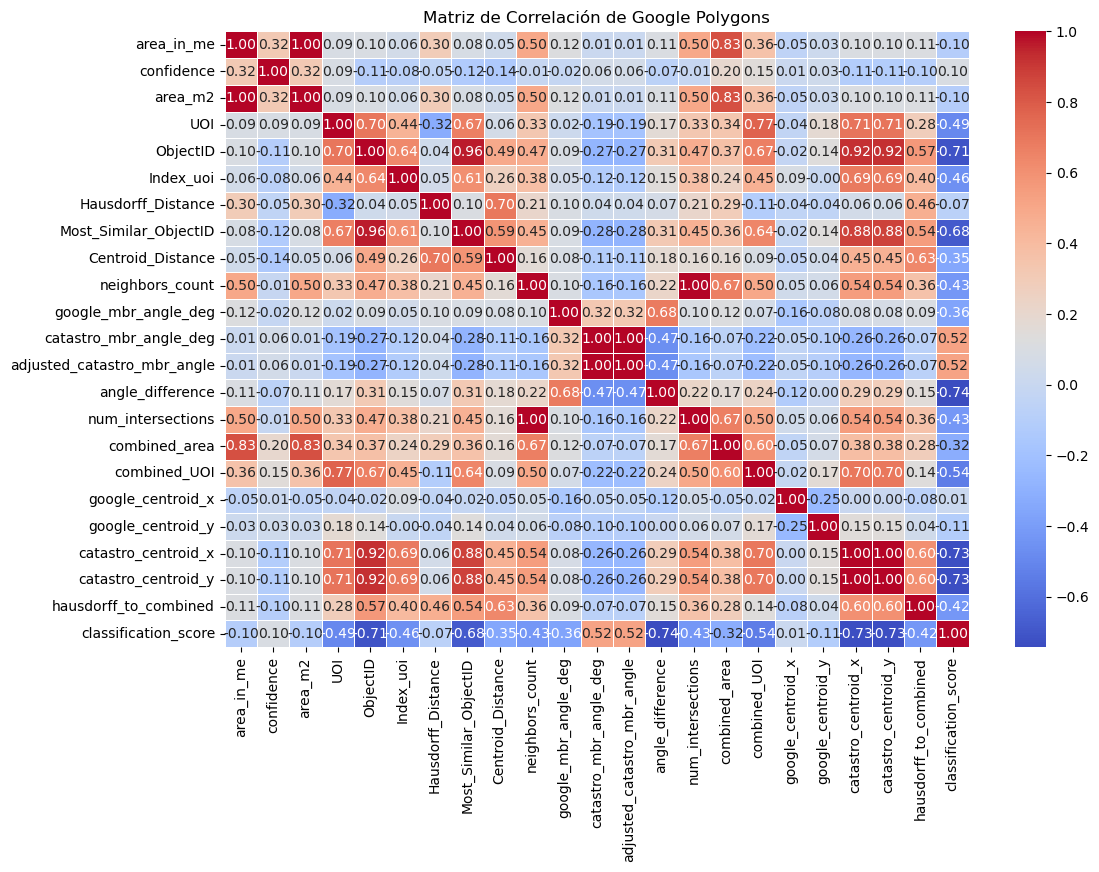

In [10]:
# Seleccionar solo las columnas numéricas
df_numeric = gdf_google.select_dtypes(include=["number"])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Crear el heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título
plt.title("Matriz de Correlación de Google Polygons")
plt.show()

## Identificación de poligonos nuevos.

### ***Keep it simple***

Primero, se calculó la proporción de la intersección de los polígonos, la diferencia en ángulos y otros acercamientos. Sin embargo, al revisar el documento agregado, las variables "classification_score" y "UOI" resumen gran parte del trabajo necesario para determinar si el registro es un polígono nuevo o no. Posteriormente, observamos en QGIS que polígonos que aparentemente eran nuevos, en relación con el catastro, podían tener puntajes de clasificación muy negativos. Por lo tanto, decidimos considerar como nuevos todos aquellos polígonos con un "classification_score" mayor a -600.

In [38]:
gdf_google["es_nuevo"] = ((gdf_google["classification_score"] > -600) & (gdf_google["UOI"] < 0.2) & (gdf_google["confidence"] > 0.70) ).astype(int)
gdf_google[gdf_google["es_nuevo"] == 1].to_parquet("./nuevos_poligonos.parquet")
gdf_google[gdf_google['es_nuevo'] == 1].to_file("nuevos_poligonos_geo.geojson", driver="GeoJSON", encoding="utf-8")

print(gdf_google["es_nuevo"].value_counts()) 

es_nuevo
0    12290
1     6009
Name: count, dtype: int64


Mejores hiperparámetros: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

Evaluando con umbral = 0.30
Accuracy: 0.8363387978142076

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86      2458
           1       0.68      0.96      0.79      1202

    accuracy                           0.84      3660
   macro avg       0.83      0.87      0.83      3660
weighted avg       0.88      0.84      0.84      3660


Evaluando con umbral = 0.50
Accuracy: 0.8795081967213115

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      2458
           1       0.76      0.92      0.83      1202

    accuracy                           0.88      3660
   macro avg       0.86      0.89      0.87      3660
weighted avg       0.89      0.88      0.88      3660


Evaluando con umbral = 0.70
Accuracy: 0.8909836065573771

Reporte de clasificación:
            

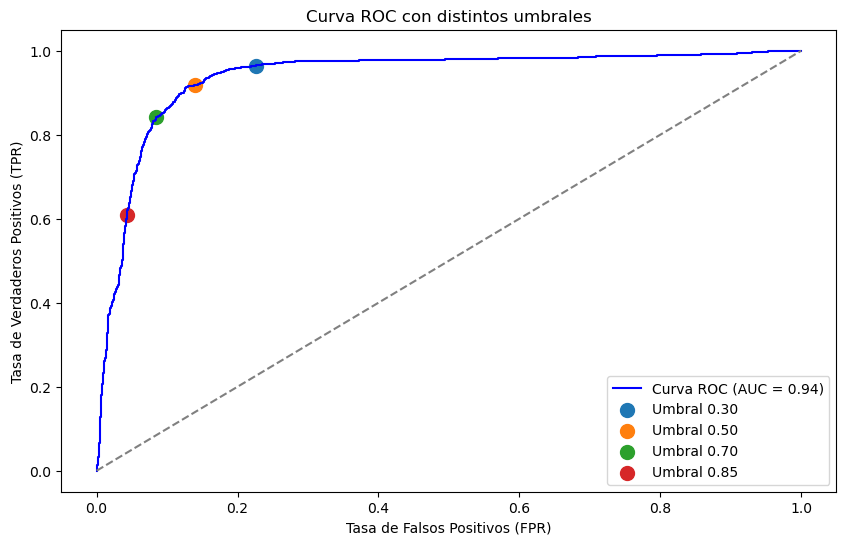

In [36]:
def evaluar_umbral(y_test, y_prob, thresholds):
    """
    Evalúa el modelo con diferentes umbrales y grafica la curva ROC.
    """
    plt.figure(figsize=(10, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color="blue", label=f"Curva ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    
    for threshold in thresholds:
        y_pred_threshold = (y_prob >= threshold).astype(int)
        print(f"\nEvaluando con umbral = {threshold:.2f}")
        print("Accuracy:", accuracy_score(y_test, y_pred_threshold))
        print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_threshold))
        closest_index = np.argmin(np.abs(_ - threshold))
        plt.scatter(fpr[closest_index], tpr[closest_index], marker="o", s=100, label=f"Umbral {threshold:.2f}")
    
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC con distintos umbrales")
    plt.legend()
    plt.show()

# Variables predictoras y objetivo
features = ["Centroid_Distance", "neighbors_count", "angle_difference", "combined_UOI" ]
target = "es_nuevo"

# Cargar y procesar datos
X, y = cargar_datos(gdf_google, features, target)
X_train, X_test, y_train, y_test = dividir_datos(X, y)
X_train_scaled, X_test_scaled, scaler = escalar_datos(X_train, X_test)

# Entrenar y optimizar modelo
best_model = optimizar_hiperparametros_logistica(X_train_scaled, y_train)

# Obtener probabilidades de predicción
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar diferentes umbrales
evaluar_umbral(y_test, y_prob, [0.3, 0.5, 0.7, 0.85])

In [ ]:
with open("./model/modelo_regresion_logistica.pkl", "wb") as file:
    pickle.dump(best_model, file)

### Justificación de Hiperparámetros modelo regresión logística
* C = 0.01 → Mayor regularización para evitar sobreajuste y mejorar la generalización.

* penalty = 'l1' → Eliminación de variables irrelevantes para un modelo más interpretable y eficiente.

* solver = 'liblinear' → Compatible con L1 y adecuado para conjuntos de datos moderados.

## **Análisis de Pérdida y Ganancia entre Umbrales 0.70 y 0.85**

El análisis de los diferentes umbrales en la clasificación de los polígonos muestra un compromiso entre la precisión y el recall en la identificación de los polígonos nuevos.

### **Datos Clave:**
#### Umbral 0.70
- **Precisión general:** 89%
- **Clase 1 (polígonos nuevos):** Precisión: 83%, Recall: 84%

### Umbral 0.85
- **Precisión general:** 84%
- **Clase 1:** Precisión: 87%, Recall: 62%

### 🔹 **Cálculo de Diferencias**

###  **Pérdida en Recall de la Clase 1**
Diferencia de recall en la clase 1:
$$ \Delta recall = 84\% - 62\% = 22\% $$
Esto significa que al subir el umbral de **0.70 a 0.85**, **se pierden 22 de cada 100 polígonos nuevos que antes se identificaban correctamente**.

**Proporción de pérdida en relación con el umbral 0.70:**
$$ \frac{84\% - 62\%}{84\%} = \frac{22}{84} \approx 26.2\% $$
🔸 **Interpretación:** Si usamos 0.85 en lugar de 0.70, **se perderá aproximadamente un 26.2% de los polígonos nuevos que antes se identificaban correctamente**.

###  **Ganancia en Precisión de la Clase 1**
Diferencia de precisión en la clase 1:
$$ \Delta precision = 87\% - 83\% = 4\% $$

**Proporción de ganancia en relación con el umbral 0.70:**
$$ \frac{87\% - 83\%}{83\%} = \frac{4}{83} \approx 4.8\% $$
🔸 **Interpretación:** Al aumentar el umbral de 0.70 a 0.85, **se gana un 4.8% en precisión en la detección de polígonos nuevos**, pero a costa de perder **26.2% en recall**.

## 🔹 **Conclusión:**
- **Si la prioridad es evitar falsos positivos**, el umbral **0.85 reduce un 4.8% los falsos positivos en la clase 1**.
- **Si la prioridad es no perder polígonos nuevos**, el umbral **0.70 es mejor, ya que clasifica un 26.2% más de polígonos nuevos correctamente**.

Dado que **el costo de omitir polígonos nuevos es alto**, la pérdida de **26.2% en recall no compensa la mínima ganancia en precisión**, lo que justifica elegir **el umbral de 0.70** como opción más equilibrada.


## Imagenes

![Poligonos nuevos frente a existentes]('.')
